# PCE 数据分析

本notebook用于分析吸收光谱数据集。

In [20]:
import os
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew

# Scikit-learn 相关模型选择与预处理
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# 模型与算法
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# 评估指标
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 如果在 Colab 环境下需要挂载云端硬盘可取消下方注释
# from google.colab import drive

以下代码用于 Google Colab

In [21]:
# DRIVE_MOUNT_PATH = "/content/drive"

# # 1. 尝试挂载 Google Drive
# print("🚀 检查 Google Drive 挂载状态...")

# if os.path.ismount(DRIVE_MOUNT_PATH):
#     print("✅ Google Drive 已挂载。")
# else:
#     print("🔄 Google Drive 未挂载，尝试进行挂载...")
#     try:
#         # 挂载 Drive，Colab 会弹出授权窗口
#         drive.mount(DRIVE_MOUNT_PATH, force_remount=True)
#         print("✅ Google Drive 挂载成功。")
#     except Exception as e:
#         print(f"❌ Google Drive 挂载失败: {e}")

In [13]:
# TARGET_FILE_DIR = os.path.join(DRIVE_MOUNT_PATH, "MyDrive", "PCEPrediction")
# DATA_FILE_NAME = os.path.join(TARGET_FILE_DIR, "data", "Mordred_descriptors_data_PCE_revised.csv")
# TARGET_FILE_PATH = os.path.join(TARGET_FILE_DIR, DATA_FILE_NAME)

# if os.path.exists(TARGET_FILE_DIR):
#     print(f"✅ 目录 '{TARGET_FILE_DIR}' 存在。")
#     project_root = TARGET_FILE_DIR
# else:
#     print(f"❌ 目录 '{TARGET_FILE_DIR}' 不存在。")

# if os.path.exists(TARGET_FILE_PATH):
#     print(f"\n✅ 文件 '{DATA_FILE_NAME}' 已存在于目标路径:\n{TARGET_FILE_PATH}")
# else:
#     print(f"\n⚠️ 文件 '{DATA_FILE_NAME}' 不存在于目标路径。")
#     print("请上传该文件，我们将它移动到指定目录。")

导入本机上的数据文件

In [22]:
TARGET_FILE_DIR = "./"
DATA_FILE_NAME = os.path.join(TARGET_FILE_DIR, "data", "Mordred_descriptors_data_PCE_revised.csv")
TARGET_FILE_PATH = os.path.join(TARGET_FILE_DIR, DATA_FILE_NAME)

if os.path.exists(TARGET_FILE_PATH):
    print(f"\n✅ 文件 '{DATA_FILE_NAME}' 已存在于目标路径:\n{TARGET_FILE_PATH}")
else:
    print(f"\n⚠️ 文件 '{DATA_FILE_NAME}' 不存在于目标路径。")
    print("请上传该文件，我们将它移动到指定目录。")


✅ 文件 './data/Mordred_descriptors_data_PCE_revised.csv' 已存在于目标路径:
././data/Mordred_descriptors_data_PCE_revised.csv


读取数据文件

In [23]:
"""
加载并预处理数据函数

参数:
csv_path (str): 数据文件路径
target_column (str): 目标变量列名
remove_unnamed (bool): 是否移除未命名列
log_transform (bool): 是否对目标变量进行对数变换
verbose (bool): 是否打印处理信息

返回:
X (DataFrame): 特征矩阵
y (Series): 目标变量
df (DataFrame): 处理后的数据框
"""
def load_data(file_path, target_column_name='PCE'):
    """
    从指定路径加载 CSV 数据，进行初步清洗，并分离特征和目标变量。

    参数:
    file_path (str): CSV 文件的完整路径。
    target_column_name (str): 目标变量的列名，默认为 'PCE'。

    返回:
    X (pd.DataFrame): 特征数据。
    y (pd.Series): 目标变量数据。
    """
    print(f"\n🚀 正在从 {file_path} 读取数据...")
    df = pd.read_csv(file_path)
    print("原始数据前5行:")
    display(df.head())
    print("原始数据信息:")
    df.info()

    # 如果存在 'Unnamed: 0' 列，则删除它
    if 'Unnamed: 0' in df.columns:
        df = df.iloc[:, 1:]
        print("已删除 'Unnamed: 0' 列。")

    print("处理后的数据前5行:")
    display(df.head())
    print("当前 DataFrame 列名:", df.columns.tolist()[:5], "...")

    # 检查目标列是否存在
    if target_column_name not in df.columns:
        raise ValueError(f"❌ 错误: 目标列 '{target_column_name}' 在数据集中不存在。")
    else:
        # 删除标签列为空的行
        initial_rows = len(df)
        df = df.dropna(subset=[target_column_name])
        if len(df) < initial_rows:
            print(f"警告: 已删除 {initial_rows - len(df)} 行，因为目标列 '{target_column_name}' 存在缺失值。")

        # 提取目标变量 y 和特征 X
        y = df.pop(target_column_name) # 提取 'PCE' 并从 df 中移除
        X = df # df 的其余部分作为特征 X
        print(f"✅ 目标变量 y ('{target_column_name}') 已提取。形状: {y.shape}")
        print(f"✅ 特征 X 已创建。形状: {X.shape}。列名: {X.columns.tolist()[:5]}...")

    return X, y

# 调用函数加载数据
X, y = load_data(TARGET_FILE_PATH)



🚀 正在从 ././data/Mordred_descriptors_data_PCE_revised.csv 读取数据...
原始数据前5行:


,Unnamed: 0,PCE,ABC,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0,52.71,28.378738,22.085071,48.068569,2.508331,4.808260,48.068569,1.264962,4.538485,...,10.395467,90.577762,522.245333,7.253407,5894,57,188,218,13.312500,8.902778
1,1,32.00,55.311853,37.018315,94.364527,2.644020,5.055713,94.364527,1.348065,5.190526,...,11.232934,128.406294,954.400119,7.456251,26176,120,378,457,17.444444,15.611111
2,3,66.00,78.396454,54.602178,132.080526,2.740383,5.227312,132.080526,1.307728,5.550731,...,11.708369,164.053606,1450.541342,7.756906,59853,186,546,674,31.972222,23.000000
3,4,68.00,49.299923,33.339471,83.819771,2.549715,4.950108,83.819771,1.309684,5.078538,...,11.004281,120.512689,899.376918,7.312007,21635,103,330,390,18.611111,14.611111
4,5,42.00,64.544681,45.829246,110.730733,2.544937,5.062404,110.730733,1.318223,5.350337,...,11.340297,141.126097,1138.475015,7.589833,33750,145,436,520,24.888889,19.333333


原始数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Columns: 1121 entries, Unnamed: 0 to mZagreb2
dtypes: float64(1058), int64(63)
memory usage: 1.1 MB
已删除 'Unnamed: 0' 列。
处理后的数据前5行:


,PCE,ABC,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,52.71,28.378738,22.085071,48.068569,2.508331,4.808260,48.068569,1.264962,4.538485,3.757845,...,10.395467,90.577762,522.245333,7.253407,5894,57,188,218,13.312500,8.902778
1,32.00,55.311853,37.018315,94.364527,2.644020,5.055713,94.364527,1.348065,5.190526,4.699575,...,11.232934,128.406294,954.400119,7.456251,26176,120,378,457,17.444444,15.611111
2,66.00,78.396454,54.602178,132.080526,2.740383,5.227312,132.080526,1.307728,5.550731,5.816845,...,11.708369,164.053606,1450.541342,7.756906,59853,186,546,674,31.972222,23.000000
3,68.00,49.299923,33.339471,83.819771,2.549715,4.950108,83.819771,1.309684,5.078538,5.248278,...,11.004281,120.512689,899.376918,7.312007,21635,103,330,390,18.611111,14.611111
4,42.00,64.544681,45.829246,110.730733,2.544937,5.062404,110.730733,1.318223,5.350337,6.953563,...,11.340297,141.126097,1138.475015,7.589833,33750,145,436,520,24.888889,19.333333


当前 DataFrame 列名: ['PCE', 'ABC', 'ABCGG', 'SpAbs_A', 'SpMax_A'] ...
✅ 目标变量 y ('PCE') 已提取。形状: (128,)
✅ 特征 X 已创建。形状: (128, 1119)。列名: ['ABC', 'ABCGG', 'SpAbs_A', 'SpMax_A', 'SpDiam_A']...


In [24]:


# 将特征 X 和目标变量 y 重新合并为一个新的 DataFrame
# 确保y是DataFrame，以便正确合并，或者y是Series，直接concat
df_new = pd.concat([X, y], axis=1)

print("合并后的 DataFrame 'df_new' 前5行:")
display(df_new.head())

print("合并后的 DataFrame 'df_new' 信息:")
df_new.info()

合并后的 DataFrame 'df_new' 前5行:


,ABC,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,PCE
0,28.378738,22.085071,48.068569,2.508331,4.808260,48.068569,1.264962,4.538485,3.757845,0.098891,...,90.577762,522.245333,7.253407,5894,57,188,218,13.312500,8.902778,52.71
1,55.311853,37.018315,94.364527,2.644020,5.055713,94.364527,1.348065,5.190526,4.699575,0.067137,...,128.406294,954.400119,7.456251,26176,120,378,457,17.444444,15.611111,32.00
2,78.396454,54.602178,132.080526,2.740383,5.227312,132.080526,1.307728,5.550731,5.816845,0.057593,...,164.053606,1450.541342,7.756906,59853,186,546,674,31.972222,23.000000,66.00
3,49.299923,33.339471,83.819771,2.549715,4.950108,83.819771,1.309684,5.078538,5.248278,0.082004,...,120.512689,899.376918,7.312007,21635,103,330,390,18.611111,14.611111,68.00
4,64.544681,45.829246,110.730733,2.544937,5.062404,110.730733,1.318223,5.350337,6.953563,0.082781,...,141.126097,1138.475015,7.589833,33750,145,436,520,24.888889,19.333333,42.00


合并后的 DataFrame 'df_new' 信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Columns: 1120 entries, ABC to PCE
dtypes: float64(1058), int64(62)
memory usage: 1.1 MB


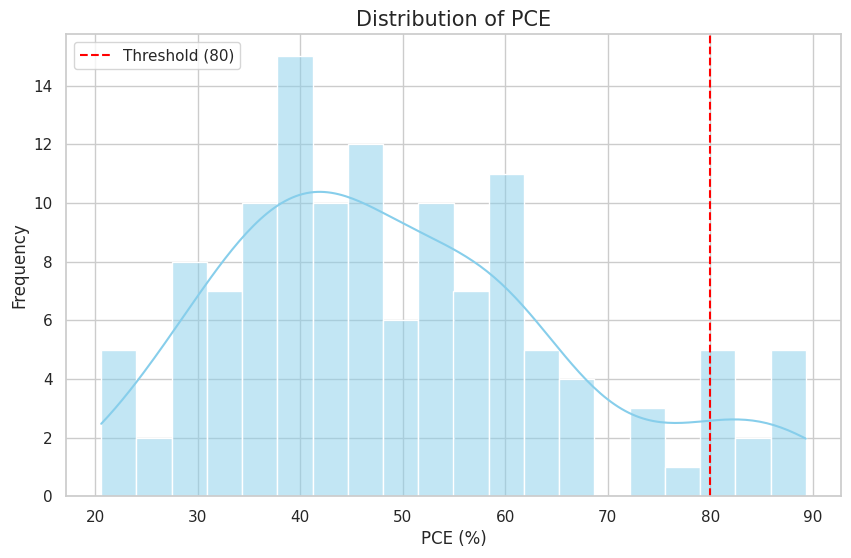

In [25]:
# ==========================================
# 2.1 绘制数据的基础直方图
# 确定 PCE 的集中区间和断层
# ==========================================
# 设置绘图风格
sns.set_theme(style="whitegrid")

def plot_pce_distribution(df, column='PCE'):
    plt.figure(figsize=(10, 6))
    
    # 绘制直方图和 KDE 曲线
    sns.histplot(df[column], kde=True, color="skyblue", bins=20)
    
    # 添加参考线（例如你关注的 80 阈值）
    plt.axvline(x=80, color='red', linestyle='--', label='Threshold (80)')
    
    plt.title(f'Distribution of {column}', fontsize=15)
    plt.xlabel('PCE (%)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.show()

plot_pce_distribution(df_new)

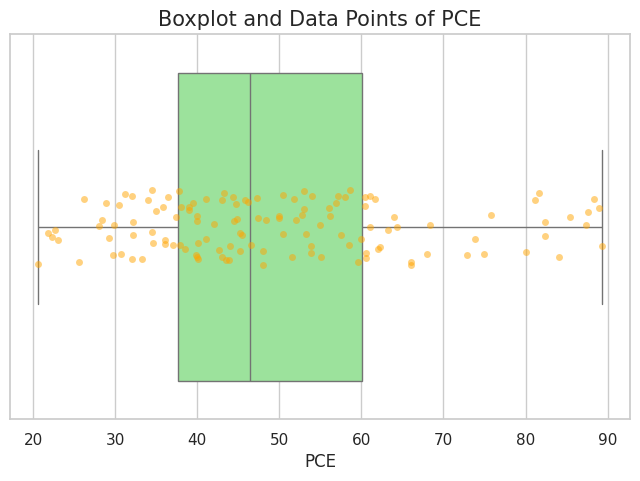

In [26]:
# ==========================================
# 2.2 绘制数据箱线图
# 识别异常值
# ==========================================
def plot_pce_boxplot(df, column='PCE'):
    plt.figure(figsize=(8, 5))
    
    # 绘制箱线图
    sns.boxplot(x=df[column], color="lightgreen")
    
    # 添加散点分布（可以看到具体每个样本的点）
    sns.stripplot(x=df[column], color="orange", alpha=0.5, jitter=True)
    
    plt.title(f'Boxplot and Data Points of {column}', fontsize=15)
    plt.show()

plot_pce_boxplot(df_new)

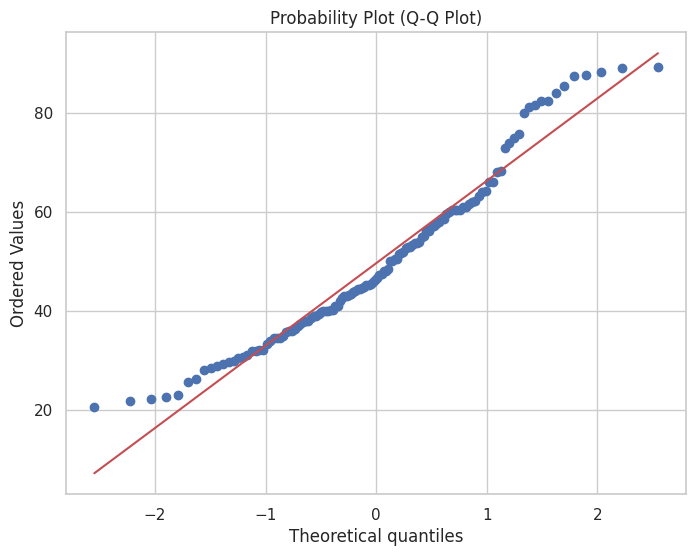

In [27]:
# ==========================================
# 2.3 绘制数据的 Q-Q 图
# 检查数据是否符合正态分布
# ==========================================
def plot_qq_plot(df, column='PCE'):
    plt.figure(figsize=(8, 6))
    stats.probplot(df[column], dist="norm", plot=plt)
    plt.title('Probability Plot (Q-Q Plot)')
    plt.show()

plot_qq_plot(df_new)

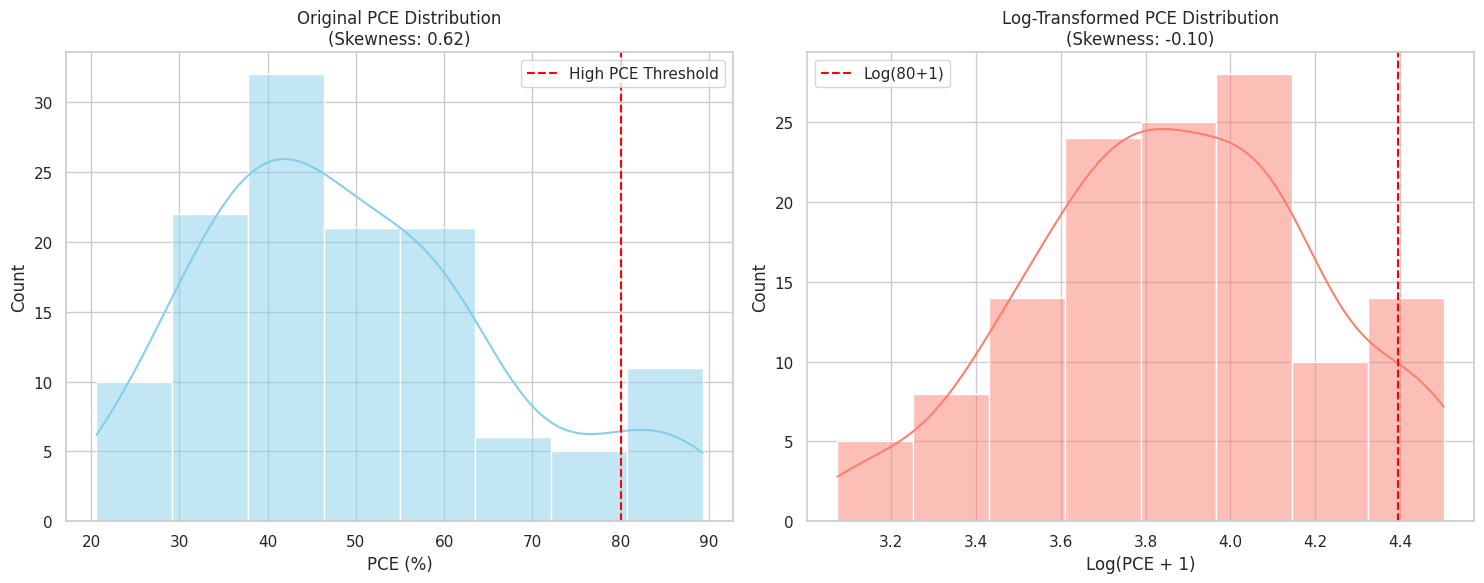

In [28]:
# ==========================================
# 2.4 将原始分布与对数变换后的分布进行对比可视化
# ==========================================
def compare_log_transform(df, column='PCE'):
    # 1. 准备数据
    original_data = df[column]
    # 对数变换：log1p 等同于 log(1 + x)
    transformed_data = np.log1p(original_data)

    # 2. 创建画布
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 3. 绘制原始分布图
    sns.histplot(original_data, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Original {column} Distribution\n(Skewness: {skew(original_data.dropna()):.2f})')
    axes[0].set_xlabel('PCE (%)')

    # 4. 绘制对数变换后的分布图
    sns.histplot(transformed_data, kde=True, ax=axes[1], color='salmon')
    axes[1].set_title(f'Log-Transformed {column} Distribution\n(Skewness: {skew(transformed_data.dropna()):.2f})')
    axes[1].set_xlabel('Log(PCE + 1)')

    # 5. 添加视觉辅助线（针对你关注的高值区 80）
    axes[0].axvline(x=80, color='red', linestyle='--', label='High PCE Threshold')
    axes[1].axvline(x=np.log1p(80), color='red', linestyle='--', label='Log(80+1)')
    
    axes[0].legend()
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# --- 使用示例 ---
# compare_log_transform(df_combined)

compare_log_transform(df_new)